In [ ]:
#Processing gene expression of 10k PBMCs

In [180]:
import os
os.chdir("/Users/juzizhenbutaitian/Desktop/python_sc/muno/tutorials/")
data_dir = "pbmc10k/"

In [46]:
# Remove file prefixes if any
prefix = "pbmc_granulocyte_sorted_10k_"
for file in os.listdir(data_dir):
    if file.startswith(prefix):
        new_filename = file[len(prefix):]
        os.rename(os.path.join(data_dir, file), os.path.join(data_dir, new_filename))

In [182]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu

In [184]:
mdata = mu.read_10x_h5(os.path.join(data_dir, "filtered_feature_bc_matrix.h5"))
mdata.var_names_make_unique()
mdata

/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from pbmc10k/filtered_feature_bc_matrix.h5


/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:477: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from pbmc10k/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: pbmc10k/atac_fragments.tsv.gz


[W::hts_idx_load3] The index file is older than the data file: pbmc10k/atac_fragments.tsv.gz.tbi


MuData object with n_obs × n_vars = 11909 × 144978
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [ ]:
#RNA

In [186]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 11909 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [ ]:
#RNA QC

In [188]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

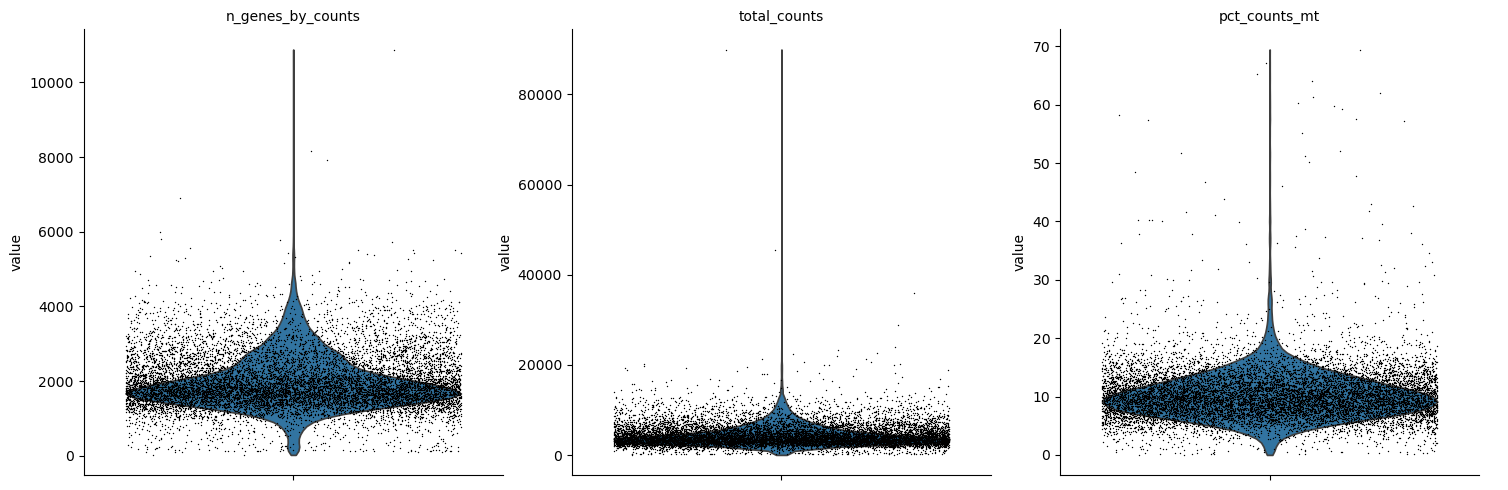

In [190]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [192]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

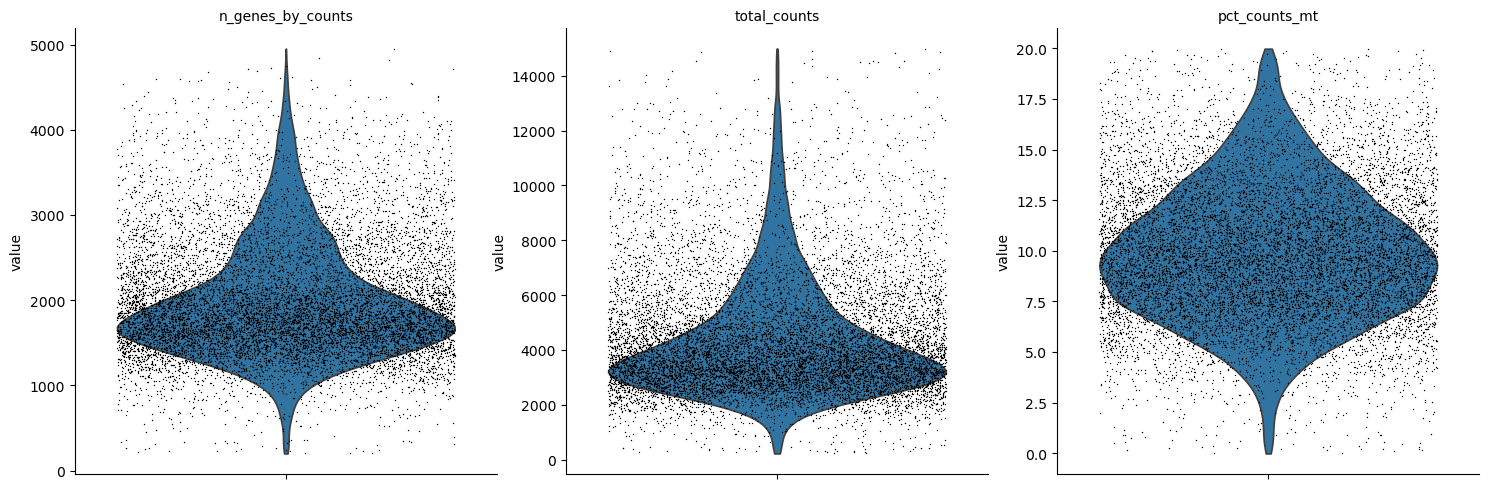

In [194]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [196]:
#Normalisation
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

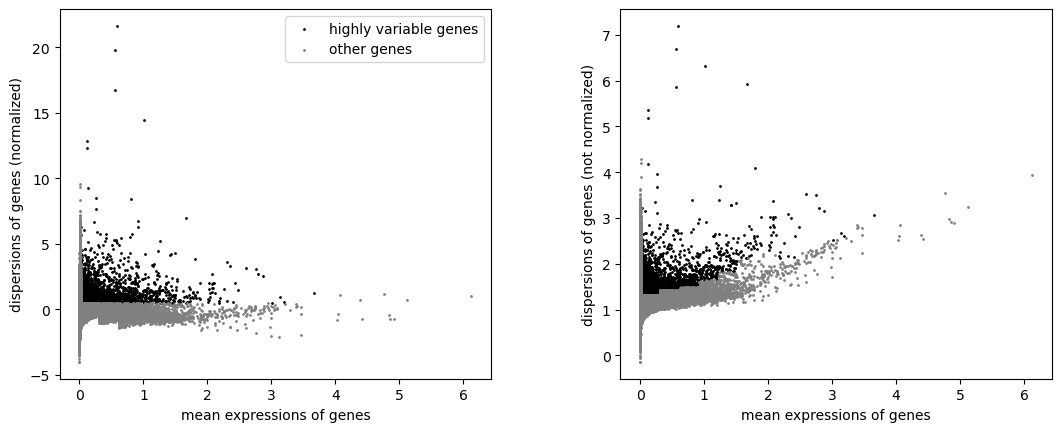

In [198]:
#Feature selection
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna)

In [200]:
np.sum(rna.var.highly_variable)

3026

In [202]:
#Scaling
rna.raw = rna
sc.pp.scale(rna, max_value=10)

In [204]:
#Individual analysis
#PCA and neighbourhood graph
sc.tl.pca(rna, svd_solver='arpack')

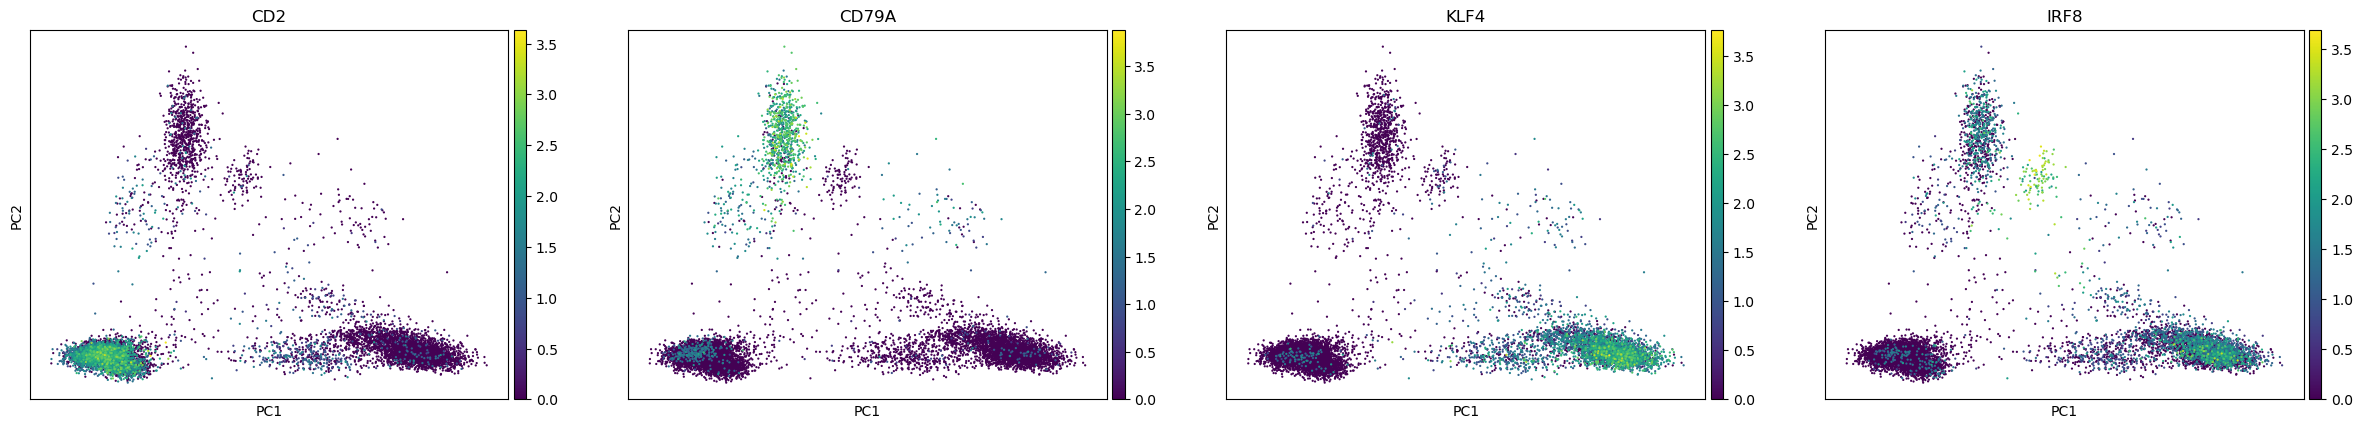

In [206]:
sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'])

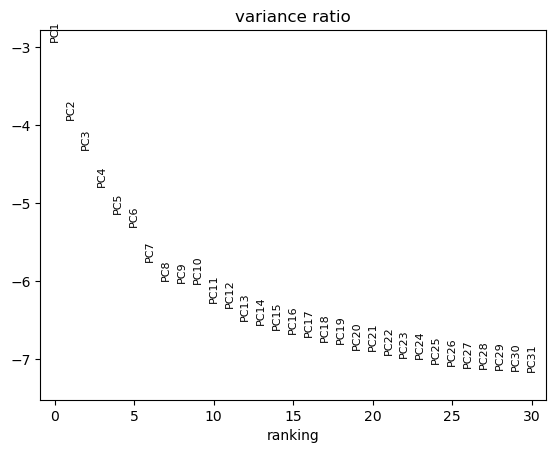

In [208]:
sc.pl.pca_variance_ratio(rna, log=True)

In [210]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

In [212]:
# reduction and clustering
sc.tl.leiden(rna, resolution=.5)

In [214]:
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)

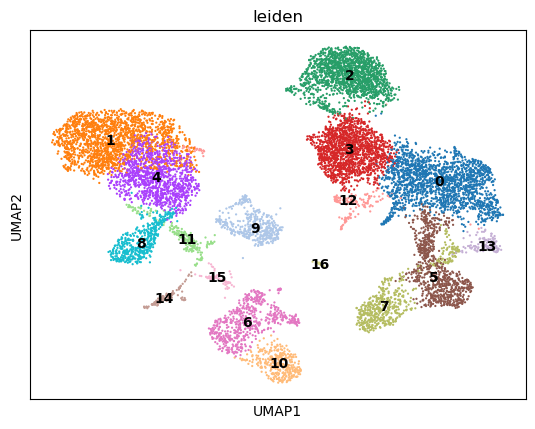

In [216]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

In [218]:
marker_genes = ['IL7R', 'TRAC',
                'ITGB1', # CD29
                'SLC4A10',
                'CD8A', 'CD8B', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHM', 'IGHD',
                'IL4R', 'TCL1A',
                'KLF4', 'LYZ', 'S100A8', 'ITGAM', # CD11b
                'CD14', 'FCGR3A', 'MS4A7',
                'CST3', 'CLEC10A', 'IRF8', 'TCF4']

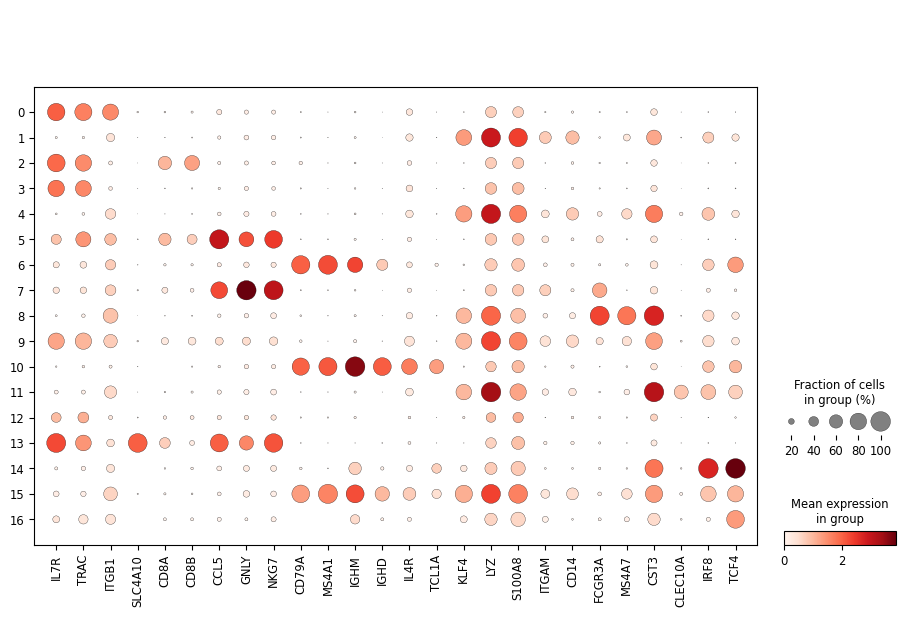

In [220]:
sc.pl.dotplot(rna, marker_genes, groupby='leiden')

In [222]:
#Marker gene and celltypes
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')

In [224]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

0_n            0_p       1_n  1_p     2_n  2_p     3_n            3_p  \
0    INPP4B   0.000000e+00    PLXDC2  0.0    LEF1  0.0    LEF1   0.000000e+00   
1      IL32   0.000000e+00      VCAN  0.0   BACH2  0.0  BCL11B   0.000000e+00   
2       LTB   0.000000e+00      DPYD  0.0   PDE3B  0.0   BACH2   0.000000e+00   
3      ANK3   0.000000e+00  ARHGAP26  0.0  THEMIS  0.0    FHIT   0.000000e+00   
4     SYNE2   0.000000e+00     LRMDA  0.0   NELL2  0.0   CAMK4   0.000000e+00   
5    CDC14A   0.000000e+00     NEAT1  0.0  BCL11B  0.0  MALAT1   0.000000e+00   
6      IL7R   0.000000e+00      FCN1  0.0   CAMK4  0.0  RPS27A   0.000000e+00   
7     ITGB1  8.297408e-313      ZEB2  0.0  OXNAD1  0.0   RPS27  2.478709e-301   
8    BCL11B   0.000000e+00     CSF3R  0.0    CD8B  0.0    TCF7  5.679182e-268   
9  ARHGAP15   0.000000e+00   DENND1A  0.0     TXK  0.0    RPL3  8.625856e-290   

      4_n  4_p    5_n            5_p      6_n            6_p    7_n  \
0  SLC8A1  0.0   CCL5   0.000000e+00    BANK1   0.000000e+00   GNLY   
1    AOAH  0.0   NKG7  6.546788e-264     CD74   0.000000e+00   NKG7   
2   NEAT1  0.0   IL32  5.707417e-285  RALGPS2  2.564292e-316  CD247   
3    TYMP  0.0  SYNE2  2.601550e-216     AFF3  1.996289e-313   PRF1   
4  PLXDC2  0.0  PRKCH  6.220664e-203    MS4A1  1.361486e-278  KLRD1   
5    DPYD  0.0   GZMA  1.998589e-175  OSBPL10  8.911786e-228   GZMA   
6    FCN1  0.0  SKAP1  4.924032e-185  HLA-DRA  6.100698e-255  SYNE1   
7    JAK2  0.0    A2M  9.922507e-164    CD79A  1.017953e-225  PRKCH   
8    ZEB2  0.0  HLA-B  8.705454e-170     PAX5  4.409137e-221   CTSW   
9    SAT1  0.0  SYNE1  7.294173e-161      BLK  1.280630e-195  MCTP2   

             7_p     8_n            8_p     9_n            9_p     10_n  \
0   0.000000e+00  TCF7L2   0.000000e+00   NEAT1  3.539250e-211     IGHM   
1  1.322678e-278    PSAP   0.000000e+00  PLXDC2  5.837117e-182     AFF3   
2  1.510339e-282     LYN   0.000000e+00    ZEB2  3.822007e-166    BANK1   
3  5.082463e-224    SAT1   0.000000e+00    LYST  2.413636e-152     CD74   
4  2.917586e-175   MTSS1  2.296504e-292    DPYD  2.703464e-156    FCRL1   
5  3.913504e-171    CST3  1.103612e-288  SLC8A1  3.767650e-141  RALGPS2   
6  4.917199e-165    WARS  3.602331e-282    TYMP  3.349483e-145  HLA-DRA   
7  8.991914e-170    CTSS  1.027859e-312     LYN  4.655642e-143    BACH2   
8  7.274819e-158   COTL1  4.033831e-275    FCN1  8.937267e-135     PAX5   
9  1.457124e-153    TYMP  1.384530e-293    AOAH  4.788480e-141    MS4A1   

            10_p      11_n           11_p   12_n          12_p     13_n  \
0  1.717856e-288      CD74  5.603001e-158  RPS29  4.774915e-18  SLC4A10   
1  7.544407e-270      CST3  2.919029e-111  RPS12  1.381091e-17  PHACTR2   
2  4.769399e-241   HLA-DRA  1.505673e-112  RPS27  1.739594e-15     NKG7   
3  1.556830e-232       LYZ  3.794375e-112  RPL13  3.090875e-15     RORA   
4  6.639286e-170  HLA-DRB1  2.083306e-106  RPS14  1.373300e-13    SYNE2   
5  3.628664e-166     HDAC9  3.582189e-104  RPS26  7.540618e-12     IL7R   
6  5.218844e-177    SAMHD1  8.075316e-107  RPL30  1.513360e-11    SKAP1   
7  8.734901e-164  HLA-DPA1   8.309513e-95  RPS21  2.386873e-11      A2M   
8  3.466939e-149  HLA-DQA1   3.669833e-90  RPL28  4.803257e-11    KLRB1   
9  3.121567e-133  HLA-DQB1   1.083042e-89  RPS18  1.212138e-10     CCL5   

           13_p      14_n           14_p     15_n          15_p    16_n  \
0  1.133609e-55      TCF4  2.131765e-108    BANK1  3.763640e-47    CDK6   
1  5.608206e-47      RHEX   9.108035e-85     AFF3  3.540132e-43   MAML3   
2  1.120089e-46      IRF8   2.498904e-83     CD74  4.056783e-40    SOX4   
3  2.642897e-42    FCHSD2   1.102101e-83   MARCH1  3.041282e-38  NKAIN2   
4  1.361929e-41      UGCG   2.849753e-78      LYN  1.349808e-37   RPLP0   
5  2.665098e-37      AFF3   3.814362e-81  HLA-DRA  1.141578e-35   RACK1   
6  2.172272e-37      CD74   5.871153e-85   PLXDC2  9.282733e-33  RNF220   
7  2.405911e-36      PLD4   6.527470e-73    MEF2C  5.807974e-31   ZNRF1   
8  1.93

In [226]:
mu.pp.filter_obs(rna, "leiden", lambda x: ~x.isin(["9", "15", "12", "16"]))

In [228]:
new_cluster_names = {
    "0": "CD4+ memory T", "1": "CD14 mono", "3": "CD4+ naïve T",
    "5": "CD8+ activated T", "7": "NK", "13": "MAIT",
    "6": "memory B", "10": "naïve B",
    "4": "intermediate mono", "2": "CD8+ naïve T", "8": "CD16 mono",
    "11": "mDC", "14": "pDC",
}

rna.obs['celltype'] = rna.obs.leiden.astype("str").values
rna.obs.celltype = rna.obs.celltype.astype("category")
rna.obs.celltype = rna.obs.celltype.cat.rename_categories(new_cluster_names)

In [236]:
rna.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
    'naïve B', 'memory B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'mDC', 'pDC'])

AAACAGCCAAGGAATC-1        CD8+ naïve T
AAACAGCCAATCCCTT-1       CD4+ memory T
AAACAGCCAATGCGCT-1        CD4+ naïve T
AAACAGCCACCAACCG-1        CD8+ naïve T
AAACAGCCAGGATAAC-1        CD4+ naïve T
                            ...       
TTTGTTGGTGTTAAAC-1        CD8+ naïve T
TTTGTTGGTTAGGATT-1                  NK
TTTGTTGGTTGCAGTA-1       CD4+ memory T
TTTGTTGGTTGGTTAG-1       CD4+ memory T
TTTGTTGGTTTGCAGA-1    CD8+ activated T
Name: celltype, Length: 10893, dtype: category
Categories (13, object): ['CD4+ naïve T', 'CD4+ memory T', 'MAIT', 'CD8+ naïve T', ..., 'intermediate mono', 'CD16 mono', 'mDC', 'pDC']

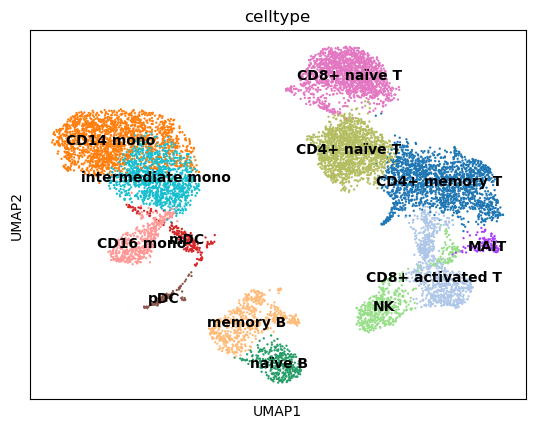

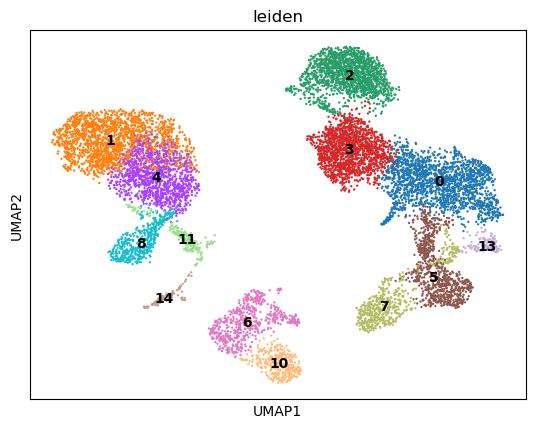

In [238]:
import matplotlib
import matplotlib.pyplot as plt
cmap = plt.get_cmap('summer')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))
sc.pl.umap(rna, color="celltype", legend_loc="on data")
sc.pl.umap(rna, color="leiden", legend_loc="on data")

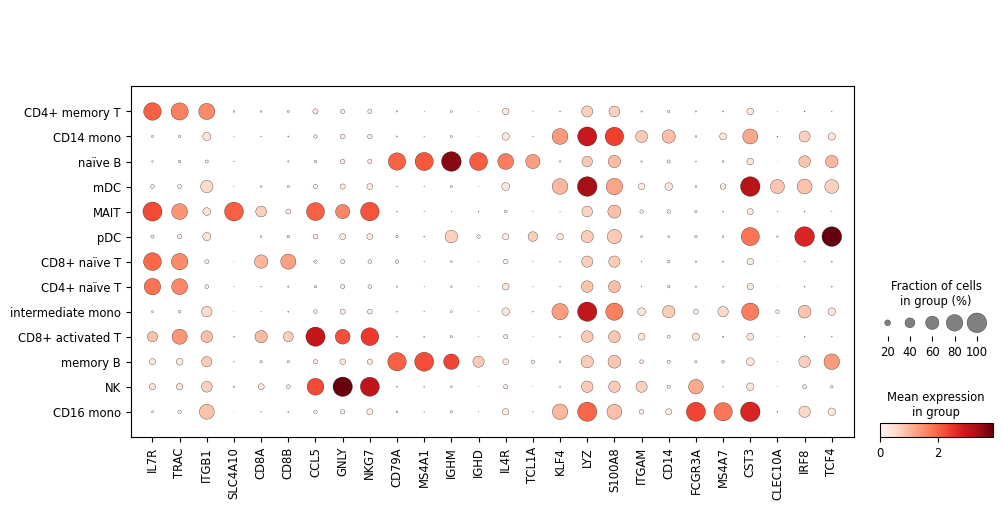

In [234]:
sc.pl.dotplot(rna, marker_genes, groupby='celltype')

In [240]:
mdata.write("pbmc10k/pbmc10k.h5mu")

In [ ]:
#Processing chromatin accessibility of 10k PBMCs

In [242]:
# Import a module with ATAC-seq-related functions
from muon import atac as ac

In [244]:
mdata = mu.read("pbmc10k/pbmc10k.h5mu")
mdata

MuData object with n_obs × n_vars = 11909 × 134726
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	10893 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [246]:
atac = mdata.mod['atac']
atac

AnnData object with n_obs × n_vars = 11909 × 108377
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

In [ ]:
#QC propocessing

In [248]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

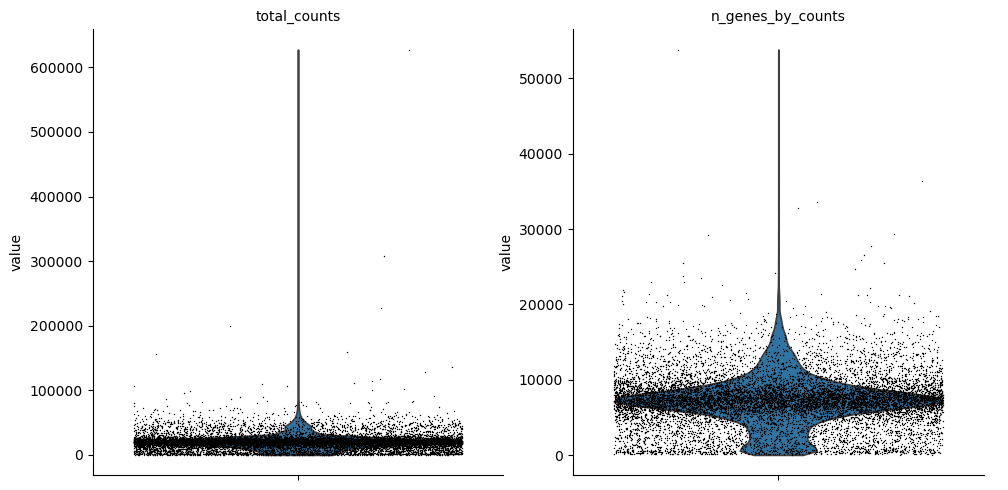

In [250]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

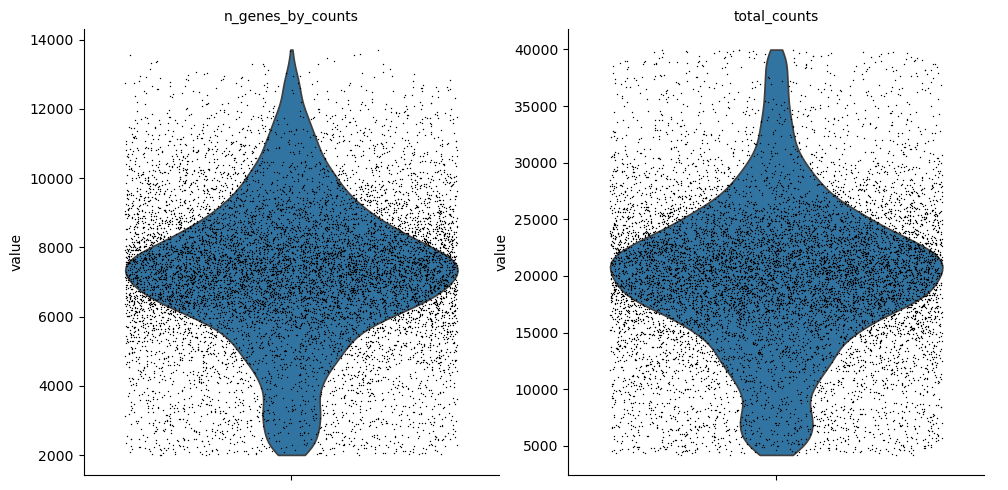

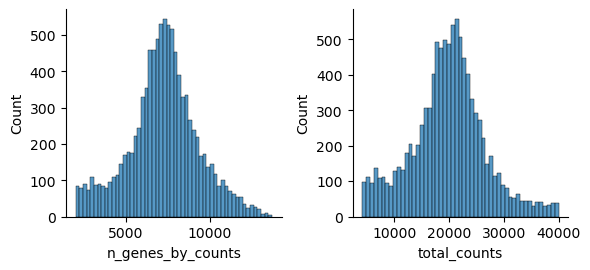

In [254]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])

[W::hts_idx_load3] The index file is older than the data file: pbmc10k/atac_fragments.tsv.gz.tbi
Fetching Regions...: 100%|████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


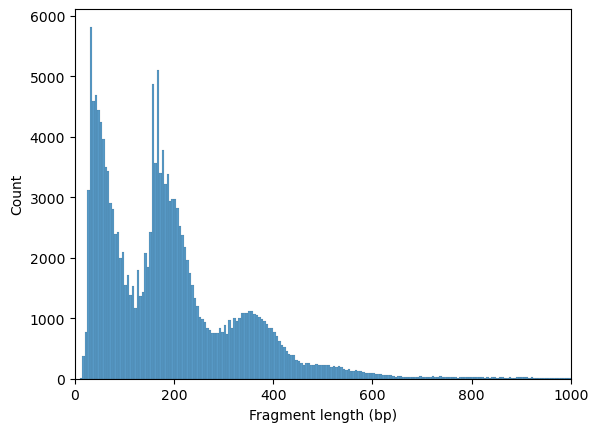

[W::hts_idx_load3] The index file is older than the data file: pbmc10k/atac_fragments.tsv.gz.tbi
Reading Fragments: 100%|██████████| 1000000/1000000 [00:01<00:00, 781345.93it/s]


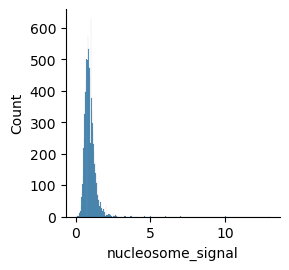

In [260]:
atac.obs['NS']=1
ac.pl.fragment_histogram(atac, region='chr5:1-2000000')

ac.tl.nucleosome_signal(atac, n=1e6)
mu.pl.histogram(atac, "nucleosome_signal", kde=False)

In [262]:
#TSS enrichment
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)
tss

[W::hts_idx_load3] The index file is older than the data file: pbmc10k/atac_fragments.tsv.gz.tbi
Fetching Regions...: 100%|█████████████████| 1000/1000 [00:06<00:00, 148.83it/s]
/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 10069 × 2001
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

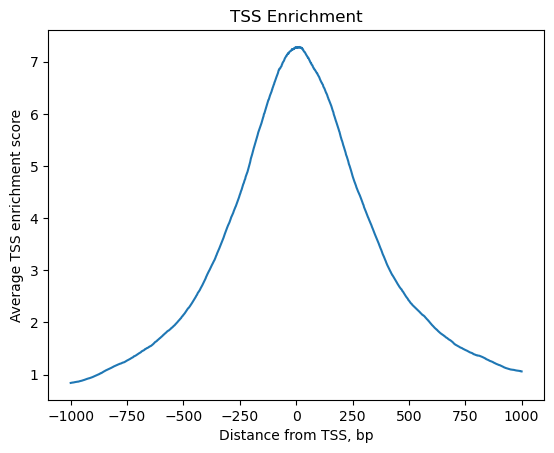

In [264]:
ac.pl.tss_enrichment(tss)

In [266]:
#Normalization
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

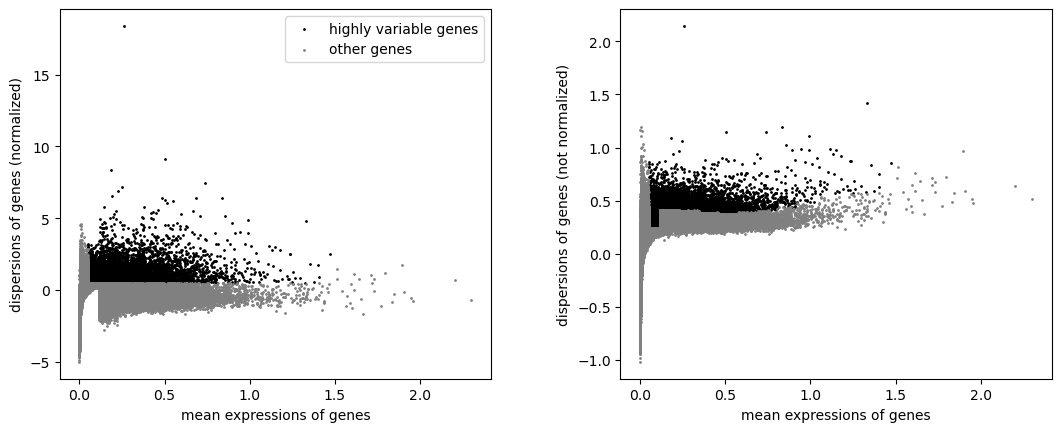

In [268]:
#Feature selection and Scaling
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)
sc.pl.highly_variable_genes(atac)

In [270]:
np.sum(atac.var.highly_variable)

14896

In [272]:
#Scaling
atac.raw = atac

In [274]:
#PCA
sc.pp.scale(atac)
sc.tl.pca(atac)

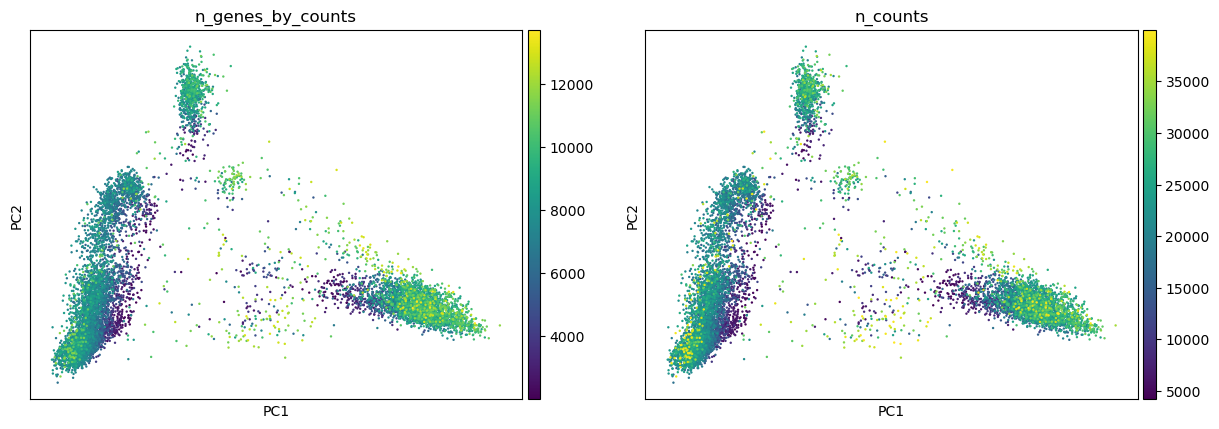

In [276]:
sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"])

In [278]:
atac.uns['atac']['peak_annotation'].tail()

# Alternatively add peak annotation from a TSV file
# ac.tl.add_peak_annotation(atac, annotation="data/pbmc10k/atac_peak_annotation.tsv")

peak  distance peak_type
gene_name                                             
AC213203.2  KI270713.1:20444-22615      9913    distal
AC213203.2  KI270713.1:27118-28927      3601    distal
AC213203.2  KI270713.1:29485-30706      1822    distal
AC213203.2  KI270713.1:31511-32072       456    distal
AC213203.1  KI270713.1:37129-37638      1723    distal

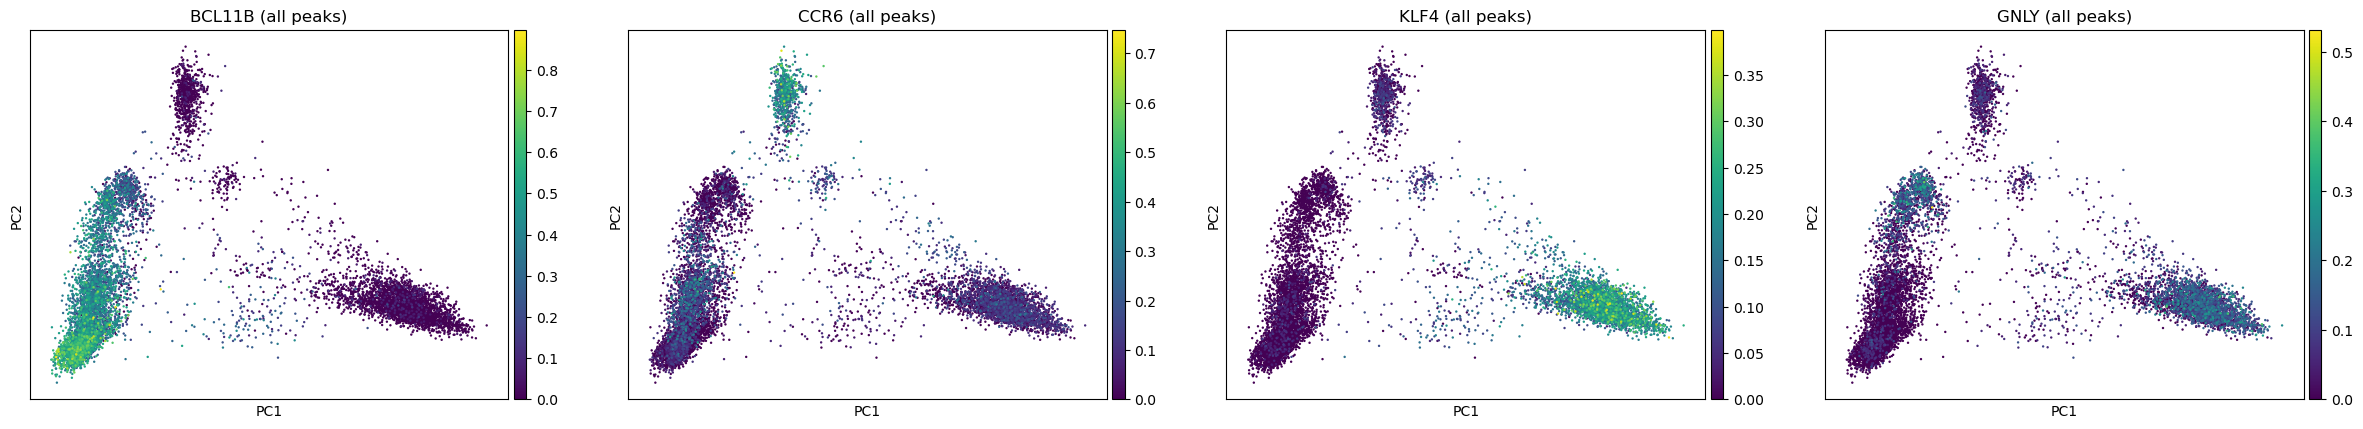

In [288]:
ac.pl.pca(atac, color=["BCL11B", "CCR6", "KLF4", "GNLY"], average="total")

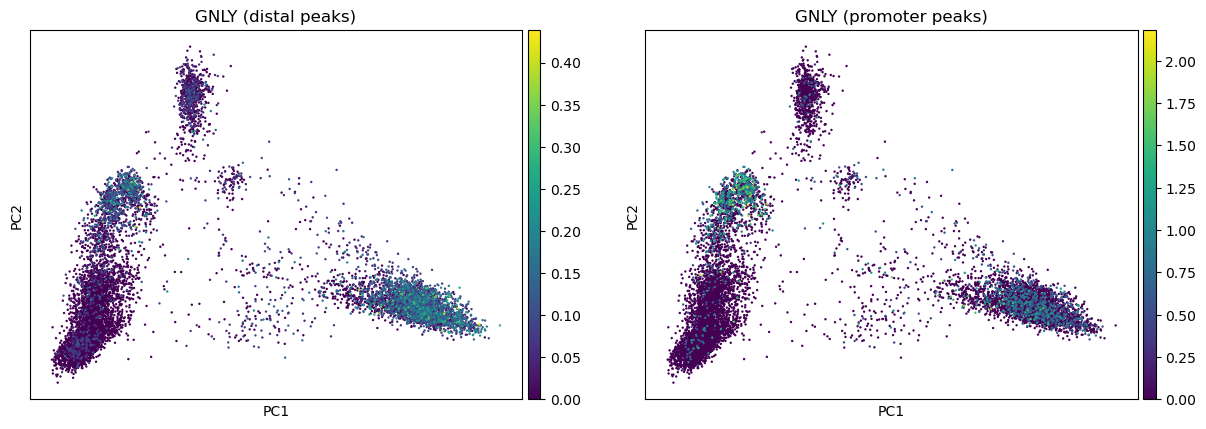

In [286]:
ac.pl.pca(atac, color="GNLY", average="peak_type")

In [290]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

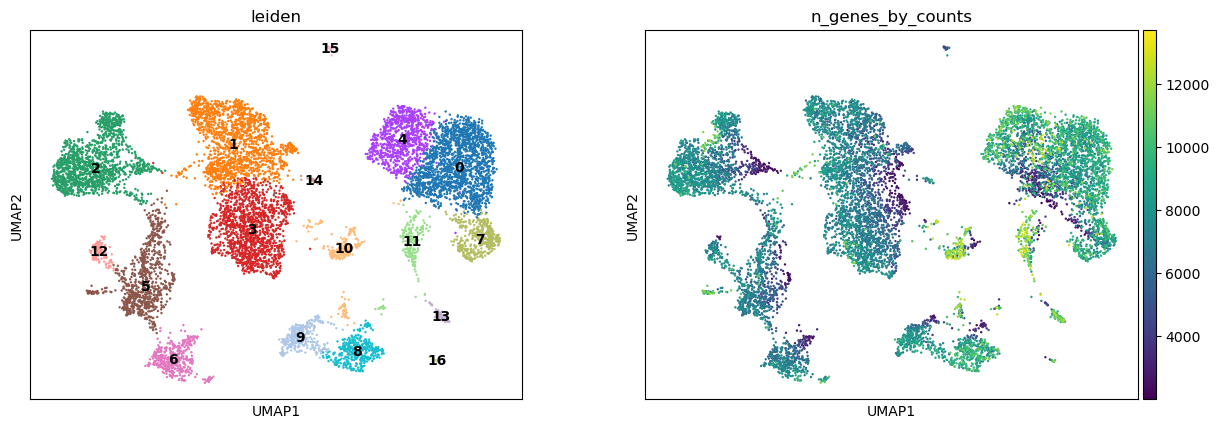

In [314]:
#Dimensionality reduction and clustering
sc.tl.leiden(atac, resolution=.55)
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

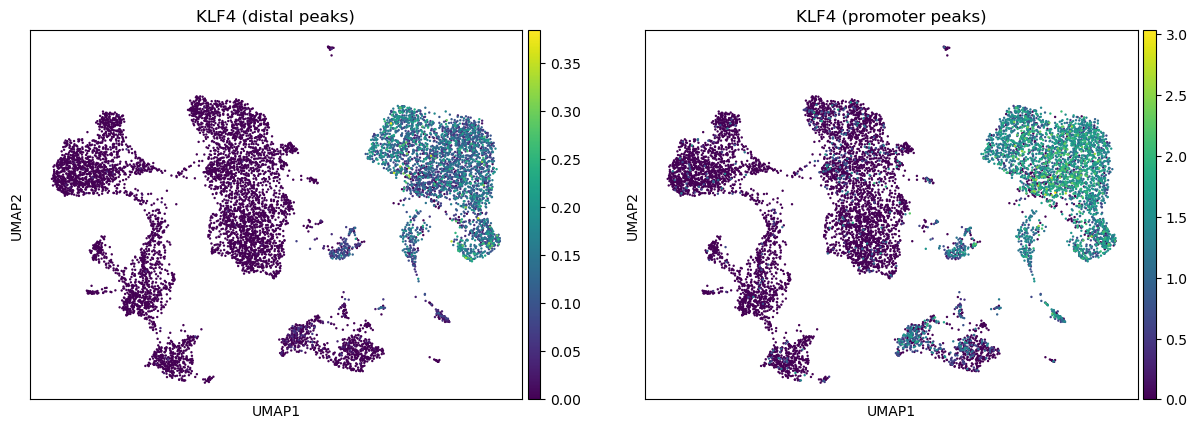

In [316]:
ac.pl.umap(atac, color=["KLF4"], average="peak_type")

In [318]:
marker_genes = ['IL7R', 'TRAC',
                'GATA3',
                'SLC4A10',
                'CD8A', 'CD8B', 'CD248', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'TNFRSF13C',
                'IL4R', 'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',
                'FCGR3A', 'MS4A7', 'CST3',
                'CLEC10A', 'IRF8', 'TCF4']

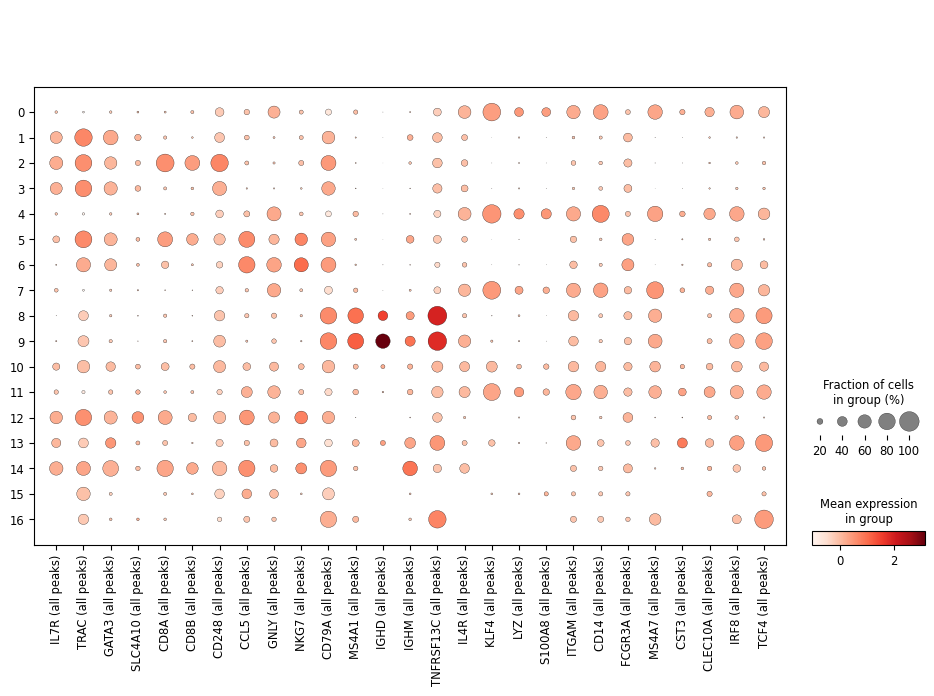

In [320]:
ac.pl.dotplot(atac, marker_genes, groupby='leiden')

In [ ]:
#Marker genes and celltypes

In [322]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [324]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option("display.max_columns", 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

0_n                       0_g            0_p  \
0  chr9:107480158-107492721                      KLF4   0.000000e+00   
1   chr11:61953652-61974246               BEST1, FTH1   0.000000e+00   
2  chr1:212604203-212626574  FAM71A, ATF3, AL590648.2   0.000000e+00   
3  chr7:106256272-106286624         NAMPT, AC007032.1   0.000000e+00   
4   chr19:13824929-13854962        ZSWIM4, AC020916.1   0.000000e+00   
5  chr9:134369462-134387253                      RXRA   0.000000e+00   
6    chr3:72092464-72103763                 LINC00877   0.000000e+00   
7  chr5:150385442-150415310               CD74, TCOF1   0.000000e+00   
8    chr6:41268623-41279829                     TREM1  3.834088e-318   
9   chr22:38950570-38958424                  APOBEC3A  1.151022e-312   

                        1_n  \
0   chr14:22536559-22563070   
1     chr10:8041366-8062418   
2   chr14:99255246-99275454   
3  chr7:142782798-142813716   
4   chr20:59157931-59168100   
5   chr14:99223600-99254668   
6   chr14:91240967-91256390   
7    chr5:35850992-35860227   
8    chr6:37512323-37518673   
9   chr12:12464985-12469154   

                                                 1_g            1_p  \
0  TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...  5.871284e-233   
1                       GATA3, GATA3-AS1, AL390294.1  1.071167e-155   
2                                 BCL11B, AL109767.1  6.242195e-157   
3  TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...  1.120125e-136   
4                                             ZNF831  3.538994e-126   
5                                 BCL11B, AL109767.1  3.305444e-125   
6                                  GPR68, AL135818.1  9.069327e-123   
7                                               IL7R  3.767714e-120   
8                                          LINC02520  2.314662e-117   
9                                 BORCS5, AC007619.1  3.434333e-114   

                         2_n                 2_g            2_p  \
0     chr2:86783559-86792275                CD8A  3.431187e-319   
1    chr14:99255246-99275454  BCL11B, AL109767.1  2.721630e-273   
2    chr11:66311352-66319301   CD248, AP001107.3  2.454346e-252   
3    chr12:10552886-10555668           LINC02446  1.662248e-216   
4   chr2:136122469-136138482               CXCR4  5.631501e-223   
5    chr14:99181080-99219442  BCL11B, AL162151.1  3.282770e-211   
6    chr14:99223600-99254668  BCL11B, AL109767.1  1.628509e-206   
7     chr1:24500773-24509089      RCAN3, RCAN3AS  1.562868e-185   
8    chr17:82125073-82129615              CCDC57  7.305060e-182   
9  chr11:118906756-118931379               BCL9L  1.119309e-176   

                        3_n  \
0   chr14:99255246-99275454   
1   chr14:99223600-99254668   
2   chr14:99181080-99219442   
3  chr7:142782798-142813716   
4   chr14:22536559-22563070   
5   chr17:82125073-82129615   
6   chr17:40601555-40611036   
7   chr19:16363226-16378669   
8  chr1:226721241-226741499   
9   chr11:60977201-60989782   

                                                 3_g            3_p  \
0                                 BCL11B, AL109767.1  6.707715e-239   
1                                 BCL11B, AL109767.1  3.182151e-188   
2                                 BCL11B, AL162151.1  2.564657e-165   
3  TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...  1.614805e-166   
4  TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...  1.084186e-164   
5                                             CCDC57  1.715234e-149   
6                                            SMARCE1  2.239842e-140   
7                                EPS15L1, AC020917.3  3.193030e-130   
8                                              ITPKB  4.828039e-119   
9                                                CD6  2.367126e-118   

                         4_n                     4_g            4_p  \
0   chr9:107480158-107492721                    KLF4  1.729510e-199   
1  chr10:128045032-128071717                   PTPRE  4.240883e-178   
2    chr20:50269694-50277398    

In [326]:
mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["10", "14", "15", "16"]))

In [336]:
new_cluster_names = {
    "1": "CD4+ memory T", "2": "CD8+ naïve T", "3": "CD4+ naïve T",
    "5": "CD8+ activated T", "8": "memory B", "12": "MAIT",
    "9": "naïve B", "6": "NK",
    "0": "intermediate mono", "4": "CD14 mono", "7": "CD16 mono",
    "11": "mDC", "13": "pDC",
}

atac.obs['celltype'] = atac.obs.leiden.astype("str").values
atac.obs.celltype = atac.obs.celltype.astype("category").cat.rename_categories(new_cluster_names)

In [346]:
atac.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
    'naïve B', 'memory B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'mDC', 'pDC'])

AAACAGCCAATCCCTT-1       CD4+ memory T
AAACAGCCAATGCGCT-1        CD4+ naïve T
AAACAGCCACCAACCG-1        CD8+ naïve T
AAACAGCCAGGATAAC-1        CD4+ naïve T
AAACAGCCAGTAGGTG-1        CD8+ naïve T
                            ...       
TTTGTTGGTGACATGC-1        CD8+ naïve T
TTTGTTGGTGTTAAAC-1        CD8+ naïve T
TTTGTTGGTTAGGATT-1                  NK
TTTGTTGGTTGGTTAG-1       CD4+ memory T
TTTGTTGGTTTGCAGA-1    CD8+ activated T
Name: celltype, Length: 9770, dtype: category
Categories (13, object): ['CD4+ naïve T', 'CD4+ memory T', 'MAIT', 'CD8+ naïve T', ..., 'intermediate mono', 'CD16 mono', 'mDC', 'pDC']

In [340]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(atac.obs.celltype.cat.categories)))

atac.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

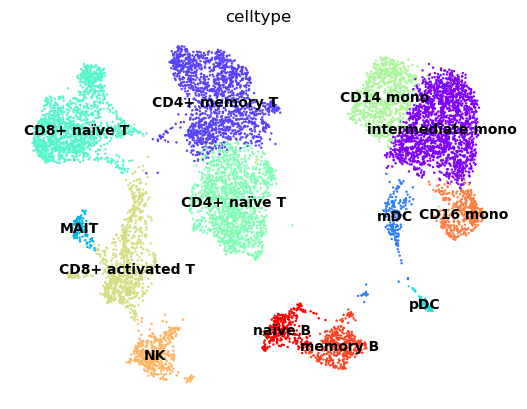

In [342]:
sc.pl.umap(atac, color="celltype", legend_loc="on data", frameon=False)

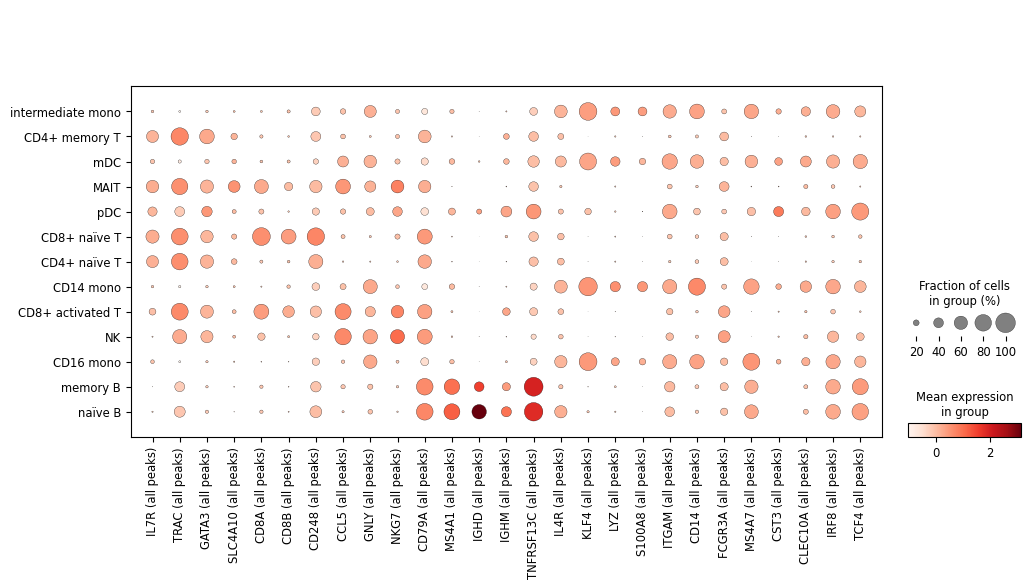

In [348]:
ac.pl.dotplot(atac, marker_genes, groupby='celltype')

In [350]:
mu.write("PBMC10K/pbmc10k.h5mu/atac", atac)

In [ ]:
#Integrating gene expression and chromatin accessibility of 10k PBMCs

In [352]:
from matplotlib import pyplot as plt
import seaborn as sns

In [354]:
mdata = mu.read("pbmc10k/pbmc10k.h5mu")
mdata

MuData object with n_obs × n_vars = 11164 × 132435
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
  2 modalities
    rna:	10893 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    atac:	9770 x 106086
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'files', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

In [356]:
mu.pp.intersect_obs(mdata)

In [358]:
mdata.shape

(9499, 132435)

In [ ]:
#Compare cell type annotation

In [360]:
from sklearn.metrics import adjusted_rand_score as ari
ari(mdata.obs['rna:celltype'], mdata.obs['atac:celltype'])

0.7459504785822519

In [362]:
# Calculate total number of cells of respective ATAC celltypes
df_total = (
    mdata.obs.groupby("atac:celltype").
        size().
        reset_index(name="n_total").
        set_index("atac:celltype")
)

# Calculate number of cells for each pair of RNA-ATAC celltype annotation
df = (
    mdata.obs.groupby(["atac:celltype", "rna:celltype"]).
        size().
        reset_index(name="n").
        set_index("atac:celltype").
        join(df_total).
        reset_index()
)

# Calculate a fraction of cells of each RNA celltype (n)
# for each ATAC celltype (/ n_total)
df_frac = df.assign(frac = lambda x: x.n / x.n_total)

/var/folders/mg/ly_z2yvn79q4dl8pmm2ws74h0000gn/T/ipykernel_31064/4070863420.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mdata.obs.groupby("atac:celltype").
/var/folders/mg/ly_z2yvn79q4dl8pmm2ws74h0000gn/T/ipykernel_31064/4070863420.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mdata.obs.groupby(["atac:celltype", "rna:celltype"]).


In [364]:
df_wide = df_frac.set_index("atac:celltype").pivot(columns="rna:celltype", values="frac")

<Axes: xlabel='rna:celltype', ylabel='atac:celltype'>

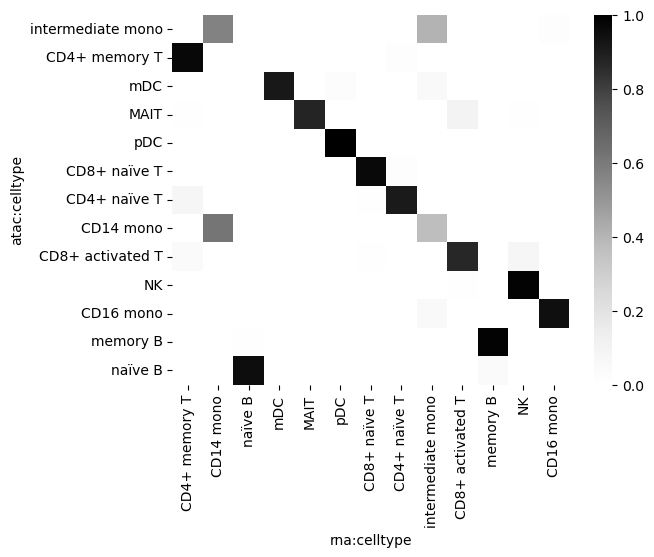

In [366]:
import seaborn as sns
sns.heatmap(df_wide, cmap="Greys")

In [370]:
#Perform integration
mu.tl.mofa(mdata, outfile="pbmc10k/pbmc10k_rna_atac.hdf5")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='group1' with N=9499 samples and D=3026 features...
Loaded view='atac' group='group1' with N=9499 samples and D=14896 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: 

In [372]:
mdata

MuData object with n_obs × n_vars = 9499 × 132435
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
  uns:	'mofa'
  obsm:	'X_mofa'
  varm:	'LFs'
  2 modalities
    rna:	9499 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    atac:	9499 x 106086
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'files', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

In [374]:
mdata.obsm['X_mofa'].shape

(9499, 10)

In [376]:
# Copy colours that were defined previously
mdata.uns = mdata.uns or dict()
mdata.uns['rna:celltype_colors'] = mdata['rna'].uns['celltype_colors']
mdata.uns['atac:celltype_colors'] = mdata['atac'].uns['celltype_colors']

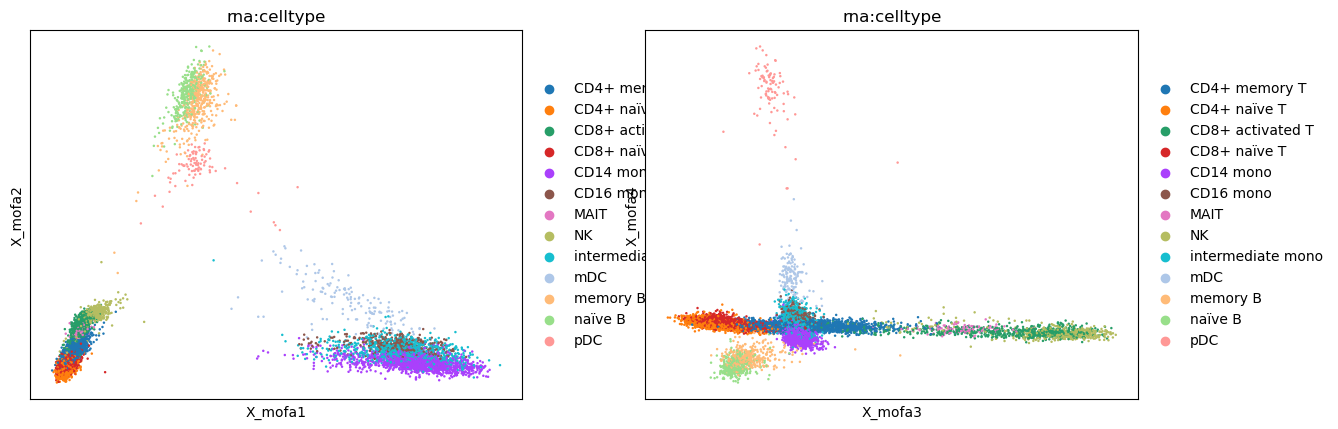

In [384]:
mu.pl.mofa(mdata, color="rna:celltype", components=["1,2", "3,4"])
# 'rna:celltype' is a column in mdata.obs
# derived from the 'celltype' column of mdata['rna'].obs

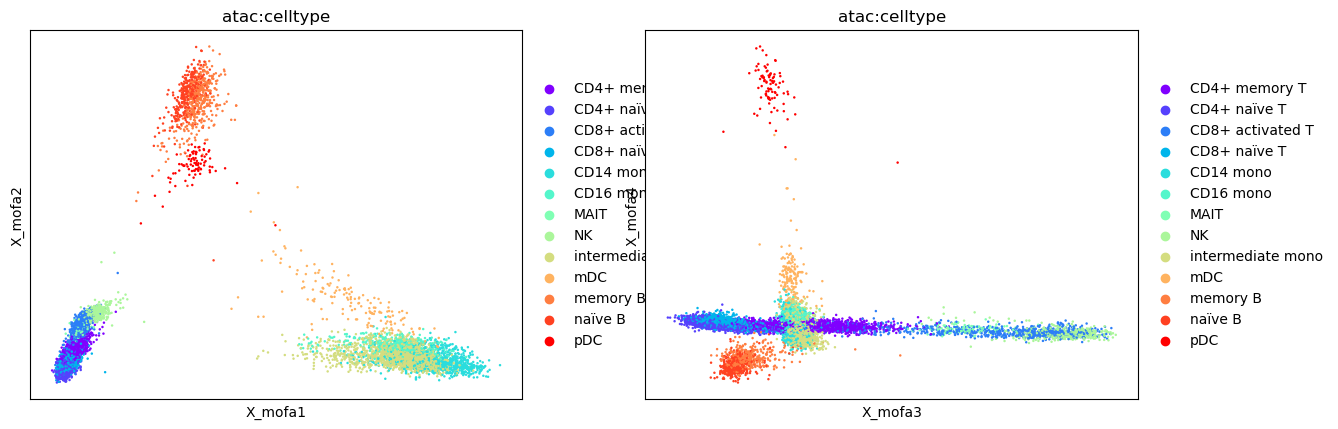

In [380]:
mu.pl.mofa(mdata, color="atac:celltype", components=["1,2", "3,4"])
# 'atac:celltype' is a column in mdata.obs
# derived from the 'celltype' column of mdata['atac'].obs

In [386]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)
sc.tl.umap(mdata, min_dist=.2, spread=1., random_state=10)

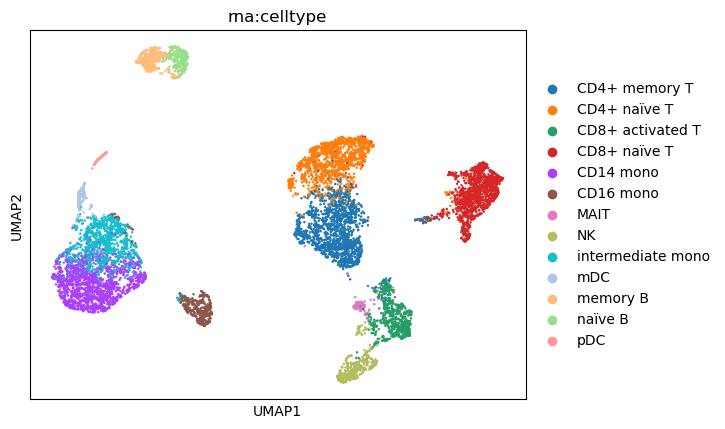

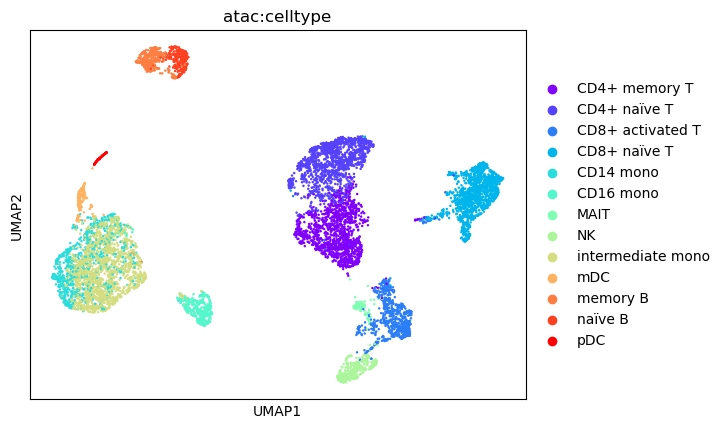

In [390]:
sc.pl.umap(mdata, color=["rna:celltype"])
sc.pl.umap(mdata, color=["atac:celltype"])

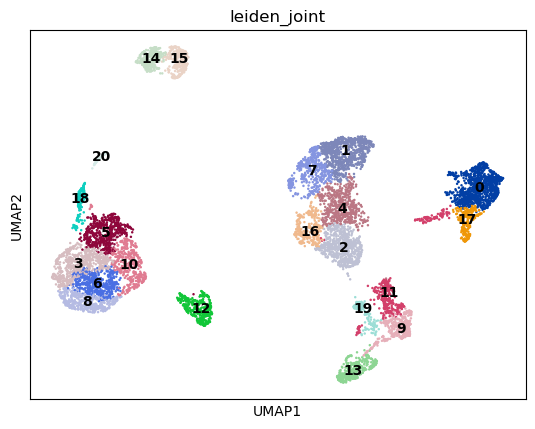

In [392]:
#UMAP jont
sc.tl.leiden(mdata, key_added='leiden_joint')
sc.pl.umap(mdata, color="leiden_joint", legend_loc='on data')

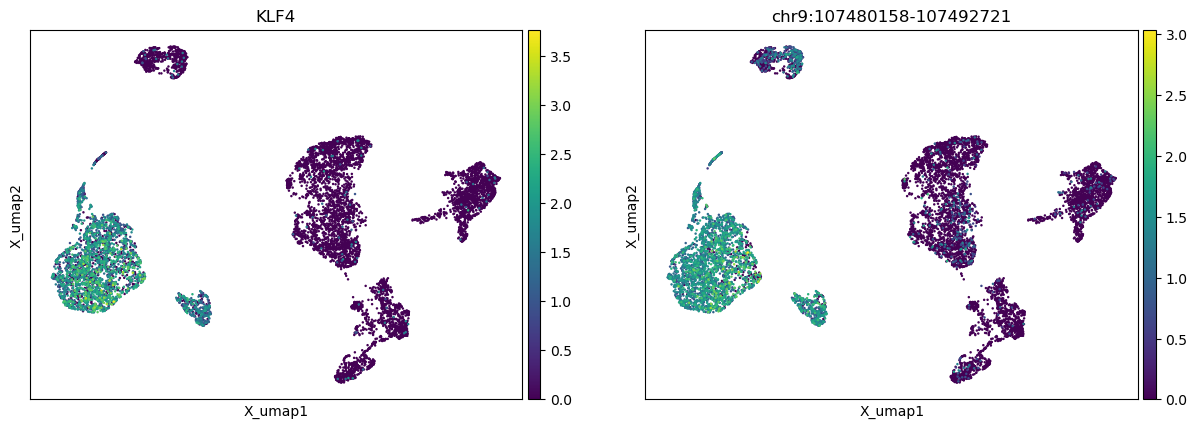

In [394]:
mu.pl.umap(mdata, color=["KLF4", "chr9:107480158-107492721"])

In [396]:
#Annotate cell types
mdata['rna'].obs['leiden_joint'] = mdata.obs.leiden_joint
mdata['atac'].obs['leiden_joint'] = mdata.obs.leiden_joint

In [398]:
#Ranking genes and peaks
sc.tl.rank_genes_groups(mdata['rna'], 'leiden_joint', method='t-test_overestim_var')
from muon import atac as ac
ac.tl.rank_peaks_groups(mdata['atac'], 'leiden_joint', method='t-test_overestim_var')

In [402]:
result = {}
result['rna'] = mdata['rna'].uns['rank_genes_groups']
result['rna']['genes'] = result['rna']['names']
result['atac'] = mdata['atac'].uns['rank_genes_groups']

groups = result['rna']['names'].dtype.names
pd.set_option("display.max_columns", 200)
pd.DataFrame(
    {mod + ':' + group + '_' + key[:1]: result[mod][key][group][:10]
    for group in groups for key in ['names', 'genes', 'pvals']
    for mod in mdata.mod.keys()})

rna:0_n                  atac:0_n rna:0_g            atac:0_g  \
0    LEF1    chr2:86783559-86792275    LEF1                CD8A   
1   NELL2   chr12:10552886-10555668   NELL2           LINC02446   
2   BACH2   chr14:99255246-99275454   BACH2  BCL11B, AL109767.1   
3  THEMIS   chr14:99181080-99219442  THEMIS  BCL11B, AL162151.1   
4    CD8B   chr11:66311352-66319301    CD8B   CD248, AP001107.3   
5   PDE3B   chr17:82125073-82129615   PDE3B              CCDC57   
6  OXNAD1    chr1:24500773-24509089  OXNAD1      RCAN3, RCAN3AS   
7    CCR7    chr2:86805831-86810178    CCR7                CD8A   
8     TXK  chr2:136122469-136138482     TXK               CXCR4   
9   CAMK4      chr1:8924588-8928112   CAMK4                 CA6   

         rna:0_p       atac:0_p rna:1_n                  atac:1_n rna:1_g  \
0  9.962126e-260  2.604536e-220    FHIT   chr14:99255246-99275454    FHIT   
1  4.805468e-238  5.070822e-170    LEF1   chr14:99223600-99254668    LEF1   
2  7.107647e-222  8.606478e-129  BCL11B   chr14:99181080-99219442  BCL11B   
3  6.810281e-226  5.067914e-126   CAMK4   chr17:82125073-82129615   CAMK4   
4  1.083942e-212  9.097234e-125   BACH2   chr17:40601555-40611036   BACH2   
5  9.632933e-215  9.028118e-108    ANK3  chr9:133700382-133704361    ANK3   
6  4.087710e-164  7.744439e-106    TCF7  chr7:142782798-142813716    TCF7   
7  3.020474e-160  1.607043e-103    CCR7  chr2:109030596-109033601    CCR7   
8  5.506623e-158  2.384345e-103  MALAT1   chr20:44066714-44073458  MALAT1   
9  2.070178e-155   1.416701e-97   MLLT3     chr20:3092185-3095713   MLLT3   

                                            atac:1_g        rna:1_p  \
0                                 BCL11B, AL109767.1  9.098628e-174   
1                                 BCL11B, AL109767.1  2.021654e-167   
2                                 BCL11B, AL162151.1  1.124181e-130   
3                                             CCDC57  4.307588e-131   
4                                            SMARCE1  7.236637e-125   
5                                              SARDH  1.584753e-101   
6  TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...  2.108811e-100   
7                                               EDAR   1.590354e-95   
8                                   TOX2, AL035447.1   3.269662e-87   
9                                                AVP   1.909561e-82   

       atac:1_p rna:2_n                  atac:2_n rna:2_g  \
0  8.032822e-93  INPP4B  chr6:137715217-137718150  INPP4B   
1  2.134846e-76    IL7R      chr1:1210271-1220028    IL7R   
2  8.871191e-75   ITGB1   chr14:22536559-22563070   ITGB1   
3  1.188901e-66    IL32   chr21:45223468-45225379    IL32   
4  1.296034e-65     LTB        chr5:756911-759750     LTB   
5  9.425832e-59    RORA      chr2:9777921-9782964    RORA   
6  1.701994e-58   SYNE2   chr12:12464985-12469154   SYNE2   
7  2.075439e-58    ANK3   chr14:64755519-64756581    ANK3   
8  1.786921e-57  CDC14A   chr15:69467756-69470179  CDC14A   
9  1.343942e-56   MDFIC      chr1:6459432-6463105   MDFIC   

                                            atac:2_g        rna:2_p  \
0                              AL356234.2, LINC02539  4.373002e-140   
1                                      SDF4, TNFRSF4  6.419047e-134   
2  TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...  2.464491e-132   
3                                  LINC00334, ADARB1  8.060728e-124   
4                               ZDHHC11B, AC026740.3  4.649487e-124   
5                                         AC082651.3  7.290201e-123   
6                                 BORCS5, AC007619.1  7.252725e-110   
7                                      SPTB, PLEKHG3  5.512200e-106   
8                                              DRAIC  3.509313e-104   
9                                     ESPN, TNFRSF25   1.436324e-82   

       atac:2_p   rna:3_n                  atac:3_n   rna:3_g  \
0  3.909375e-65    PLXDC2  chr9:107480158-107492721    PLXDC2   
1  9.511922e-63      VCAN   chr20:50269694-5027739

In [406]:
marker_genes = [
    'IL7R', 'TRAC', 'GATA3',                                # CD4+ T
    'LEF1', 'FHIT', 'RORA', 'ITGB1',                        # naïve/memory
    'CD8A', 'CD8B', 'CD248', 'CCL5',                        # CD8+ T
    'GZMH', 'GZMK',                                         # cytotoxic/transitional effector T cells
    'KLRB1', 'SLC4A10',                                     # MAIT
    'IL32',                                                 # T/NK
    'GNLY', 'NKG7',                                         # NK
    'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'IL4R', 'TNFRSF13C',  # B
    'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',               # mono
    'DPYD', 'ITGAM',                                        # classical/intermediate/non-classical mono
    'FCGR3A', 'MS4A7', 'CST3',                              # non-classical mono
    'CLEC10A', 'IRF8', 'TCF4'                               # DC
]

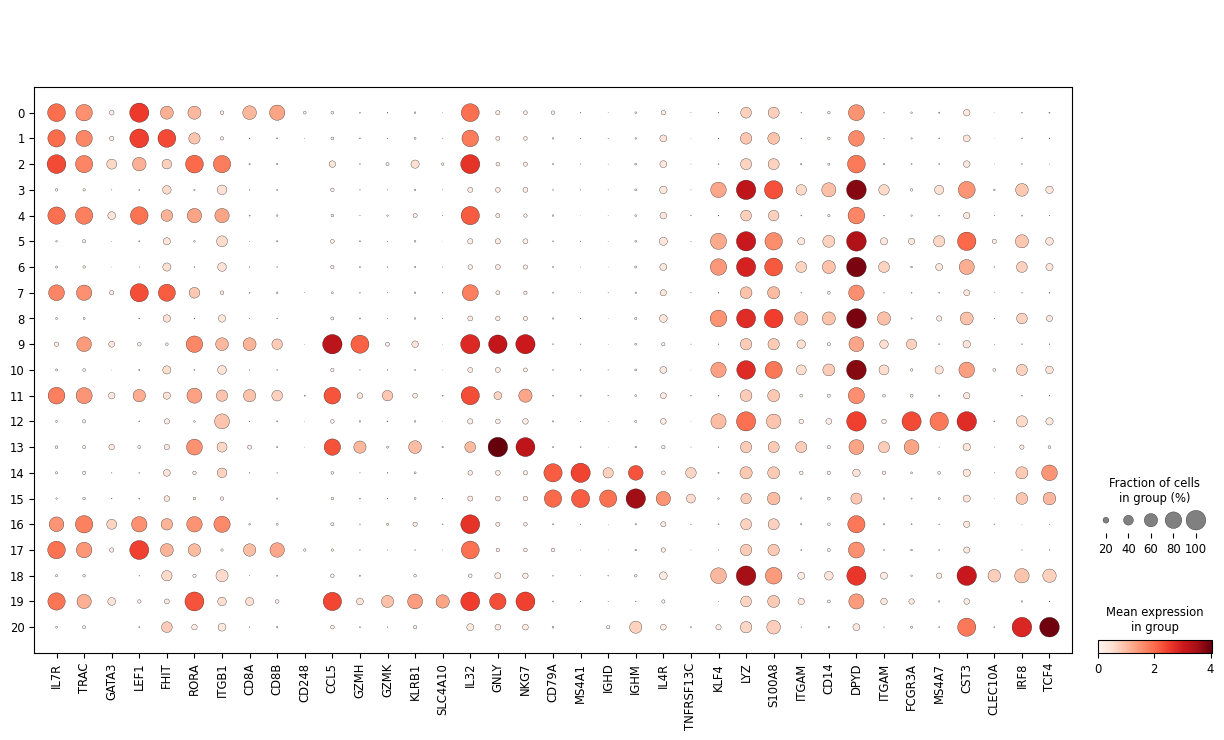

In [408]:
sc.pl.dotplot(mdata['rna'], marker_genes, 'leiden_joint')